# Using MELD to characterize TCR stimulation using thresholding
## Introduction

In this tutorial, we will demonstrate how to use MELD to characterize the effect of TCR stimulation with α-CD3/CD28 beads. Although in the MELD paper, we used VFC, here we will show a way to perform the same analysis by thresholding relative likelihood values.

We will use a dataset published in [Pooled CRISPR screening with single-cell transcriptome readout](https://pubmed.ncbi.nlm.nih.gov/28099430/) where Jurkat T cells were stimulated with α-CD3/CD28-coated beads for 10 d before collection for scRNA-seq.

A few notes on this tutorial:
1. This is not the analysis performed in the paper, and is included as a demonstration of how to use MELD without Vertex Frequency Clustering.
2. This is an abbreviated tutorial with an emphasis on MELD. For more in-depth guidance on preprocessing and analysis of single cell data, please consult best practices literature:
  * https://www.embopress.org/doi/10.15252/msb.20188746  
  * http://bioconductor.org/books/release/OSCA/  
3. Using MELD without VFC requires some thinking about how you're going to structure your analysis. The thresholds you use may be different for different kinds of cells in different regions of the manifold. I would recommend carefully considering which threshold you'd like to pick, and consider using a different threshold for different parts of cells. As is recommended in the MELD article, I would first recommend doing coarse grained clustering to characterize broad classes of cells. You may find, for example, that "enriched" for one cell type means a likelihood > 0.8, while for another group of cells, a threshold of 0.6 would suffice. Would you prefer to have "enriched" mean you're 20% more likely to find that cell in the experimental condition? In this tutorial, we sidestep that question by using a Gaussian Mixture Model to pick cutoffs for us. However, these may not apply to other datasets or even to different classes of cells within a dataset. YMMV.

## 0. Installing packages

If you haven't installed MELD yet, you can do so from this notebook. We'll also install some other useful packages while we're at it.

In [1]:
!pip install --user meld phate diffxpy

In [2]:
import pandas as pd
import numpy as np
import graphtools as gt
import phate
import magic
import scprep
import meld
import sklearn
import scipy
import seaborn as sns

# setting defaults for matplotlib font sizes
import matplotlib.pyplot as plt
plt.rc('font', size=14)

# making sure plots & clusters are reproducible
np.random.seed(42)

import diffxpy.api as de

/home/dan/.local/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Loading Raw Data

#### Loading data from GEO

The data for this paper is available from GEO: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92872

We're going to download it directly into a DataFrame. Note, the file has metadata and UMI counts in the same file, so we'll access it twice.

In [3]:
data_URL = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE92872&format=file&file=GSE92872%5FCROP%2Dseq%5FJurkat%5FTCR%2Edigital%5Fexpression%2Ecsv%2Egz"
data = pd.read_csv(data_URL, header=None, skiprows=6, index_col=0, compression="gzip").T
data.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,AAAS,AACS,AACSP1,...,bP-21264C1.1,bP-21264C1.2,bP-2168N6.3,bP-2189O9.2,chr22-38_28785274-29006793.1,hsa-mir-1587,hsa-mir-3149,hsa-mir-4259,snosnR66,yR211F11.2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
metadata = pd.read_csv(data_URL, header=None, nrows=5, index_col=0, compression="gzip").T
metadata['is_stimulated'] = metadata['condition'] == 'stimulated'
metadata.head()

,condition,replicate,cell,grna,gene,is_stimulated
1,stimulated,1,TACTTGACCCCN,CTRL00320,CTRL,True
2,stimulated,1,TTACAGCTGAAC,Tcrlibrary_JUND_2,JUND,True
3,stimulated,1,CTAAGGCCCTTA,Tcrlibrary_BACH2_3,BACH2,True
4,stimulated,1,CTTGACGCAGGT,Tcrlibrary_NFKB2_3,NFKB2,True
5,stimulated,1,TAACCCGTACGC,Tcrlibrary_JUN_1,JUN,True


#### Create index

The original data has only numbered indices, but this is easy to mix up using Pandas. To make sanity checks easier, we'll use a concatenation of the cell barcode, gene targeted in that cell, and the stimulation condition.

In [5]:
data.index = ['.'.join([c,g,co]) for i, (c,g, co) in metadata[['cell','gene', 'condition']].iterrows()]
metadata.index = data.index


### Filtering library size
Removing high library cells as protection against doublets.

In [6]:
data = scprep.filter.filter_library_size(data, cutoff=25000, keep_cells='below')

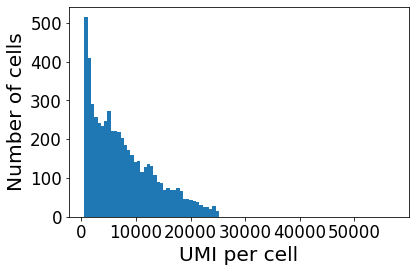

In [7]:
scprep.plot.plot_library_size(data, range=(0,60000), log=False)
plt.xlabel('UMI per cell')
plt.ylabel('Number of cells')
plt.xlim(-2219.9500000000003, 59972.95)
plt.tight_layout()
#plt.savefig('/home/dan/burkhardt/blog/figs/libsize_example_filtered.png', dpi=300, transparent=True)

In [8]:
metadata['targeting_essential'] = np.array([g in ["DHODH", "MVD", "TUBB"] for g in metadata['gene'].values])

#### Remove genes from the CRISPR library

Some cells expressed gRNA barcodes, but we don't want to use these to build a graph.

In [9]:
artificial_genes = np.array(['library' in g for g in data.columns])

data = data.loc[:,~artificial_genes]
data = scprep.filter.filter_rare_genes(data)

#### Remove low quality cells

Filtering genes based on mitochondrial RNA and other genes that were filtered in the published analysis

In [10]:
# filter mitochonrial expression & library size
mito_genes = np.array([g.startswith('MT-') for g in data.columns])
data_zs = scipy.stats.zscore(scprep.normalize.library_size_normalize(data))
mito_expression = np.mean(data_zs[:, mito_genes], axis=1)
data = data.loc[(mito_expression < 1)]

# Note, these genes were removed in the published study
mito_ribo_genes = np.array([((g.startswith('MT-')) | (g.startswith('MRP')) | (g.startswith('RP') & (~(g.startswith('RPT') | g.startswith('RPU'))))) for g in data.columns]).astype(bool)
data = data.loc[:, ~mito_ribo_genes]

# Measure library size
metadata = metadata.loc[data.index]
metadata['library_size'] = scprep.measure.library_size(data)

### Normalization and trasformation

In [11]:
# Library size normalize
data = scprep.normalize.library_size_normalize(data)
data = scprep.transform.sqrt(data)

### Run PHATE to visualize data

In [12]:
phateop = phate.PHATE()
data_phate = phateop.fit_transform(data)

Calculating PHATE...
  Running PHATE on 5591 cells and 18260 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 29.84 seconds.
    Calculating KNN search...
    Calculated KNN search in 3.45 seconds.
    Calculating affinities...
    Calculated affinities in 0.46 seconds.
  Calculated graph and diffusion operator in 42.25 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.56 seconds.
    Calculating KMeans...
    Calculated KMeans in 13.10 seconds.
  Calculated landmark operator in 14.85 seconds.
  Calculating optimal t...
  Calculated optimal t in 1.81 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.43 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 13.66 seconds.
Calculated PHATE in 73.02 seconds.


### Run MELD to calculate relative likelihood of stimulation

In [13]:
meld_op = meld.MELD()
sample_densities = meld_op.fit_transform(data, metadata['condition'])
sample_densities.index = data.index

Building graph on 5591 samples and 18260 features.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 33.67 seconds.
  Calculating KNN search...
  Calculated KNN search in 3.44 seconds.
  Calculating affinities...
  Calculated affinities in 0.45 seconds.
Calculated graph and diffusion operator in 49.59 seconds.


In [14]:
metadata['stimulated_likelihood'] = meld.utils.normalize_densities(sample_densities)['stimulated']

#### Plotting likelihood using PHATE

<AxesSubplot:>

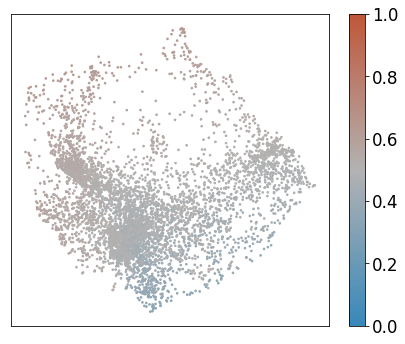

In [15]:
scprep.plot.scatter2d(data_phate, c=metadata['stimulated_likelihood'],
                      ticks=False, figsize=(6,5),
                     vmin=0, vmax=1, cmap=meld.utils.get_meld_cmap())

This looks very grey because most of the values are betwen 0.3 and 0.6, indicating that the effect of bead stimulation is small with respect to to the total biological variation.

<AxesSubplot:ylabel='Number of cells'>

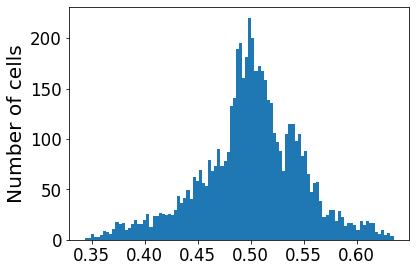

In [16]:
scprep.plot.histogram(metadata['stimulated_likelihood'])

Let's change the color bar scale to make it easier to see:

<AxesSubplot:>

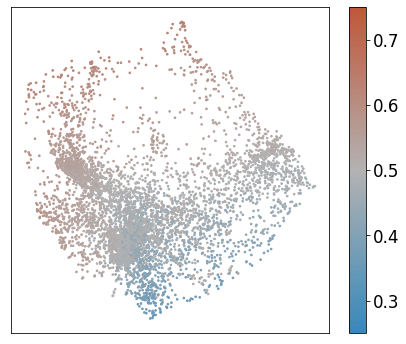

In [17]:
scprep.plot.scatter2d(data_phate, c=metadata['stimulated_likelihood'],
                      ticks=False, figsize=(6,5),
                     vmin=0.25, vmax=.75, cmap=meld.utils.get_meld_cmap())

### Thresholding the relative likelihood using a mixture model

To pick thresholds for the relative likelihood, we'll use a mixture model. Note, there are many ways to pick a threshold. You can eyeball the values (I often find that a mixture model agrees with my eyeballing). You could do KMeans on the vector! I don't want to endorse any particular approach, but just provide this as one solution. YMMV.

In [18]:
import sklearn.mixture

Fit the mixture model

In [19]:
mixture_model = sklearn.mixture.GaussianMixture(n_components=3)
classes = mixture_model.fit_predict(metadata['stimulated_likelihood'].values.reshape(-1,1))

Reorder the class labels so that 0 has the lowest average likelihood and 2 has the highest. Note this doesn't change the assignments, just the labels.

In [20]:
classes = scprep.utils.sort_clusters_by_values(classes, metadata['stimulated_likelihood'])

Plot the distribution of likelihood values for each class

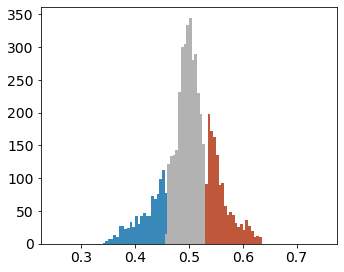

In [21]:
fig, ax = plt.subplots(1, figsize=(5,4))
for c in np.unique(classes):
    ax.hist(metadata['stimulated_likelihood'][classes == c], range=(0.25,.75), bins=100,
           color=meld.utils.get_meld_cmap()([0,255//2, 255])[c])
fig.tight_layout()

Look at the clusters over the graph

<AxesSubplot:>

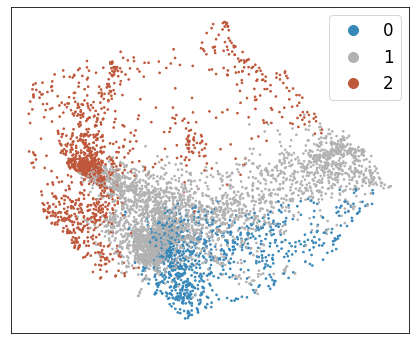

In [22]:
scprep.plot.scatter2d(data_phate, c=classes,
                      ticks=False, figsize=(6,5),
                      cmap=meld.utils.get_meld_cmap())

In [23]:
import gseapy
import diffxpy.api as de

#### Differential expression and gene sets enrichment analysis

Now that we have the cells with the highest and lowest relative likelihood values, we can characterize them using differential expression.

As a warning, although we're using a simple ranksum test here, be aware the p- and q- values are notoriously unreliable when comparing single cell clusters. [This paper](https://doi.org/10.1016/j.cels.2019.07.012) provides more details on why and proposes a test to handling the issue. Unfortunately the code accompanying the paper is tedious to use, so we'll apply a simple ranksum test and take the results with a grain of salt.

#### Differential expression using a ranksum test

In [24]:
qval_threshold = 0.05

In [25]:
# Here we take the cells from the depleted and enriched groups (class 0 and 2, respectively)
# and use them as input to the differential expresssion test
de_results = de.test.two_sample(data[np.isin(classes, [0,2])].values, 
                                grouping=classes[np.isin(classes, [0,2])],
                                gene_names=data.columns,
                                test='rank').summary()

In [26]:
significant_results = de_results.loc[de_results['qval'] < qval_threshold]
top_genes = significant_results['gene'].values

#### Gene set enrichment analysis using GSEAPY

The gene sets here are grabbed from the paper accompanying the dataset. They're known to play a role in TCR activation.

In [27]:
gene_sets = ['GO_Biological_Process_2018', 'NCI-Nature_2016']

In [28]:
terms = ['T cell activation (GO:0042110)',
         'TCR signaling in naive CD8+ T cells Homo sapiens 15a017bb-6196-11e5-8ac5-06603eb7f303', 
         'C-MYB transcription factor network Homo sapiens 61020228-618e-11e5-8ac5-06603eb7f303', 
         'TCR signaling in naive CD4+ T cells Homo sapiens 0c2862fa-6196-11e5-8ac5-06603eb7f303',
         'IL2 signaling events mediated by PI3K Homo sapiens 8bbf39aa-6193-11e5-8ac5-06603eb7f303',
         'IL6-mediated signaling events Homo sapiens e684d5d2-6193-11e5-8ac5-06603eb7f303']

terms_pretty = {
    'T cell activation (GO:0042110)':'T cell\nactivation',
    'TCR signaling in naive CD8+ T cells Homo sapiens 15a017bb-6196-11e5-8ac5-06603eb7f303':'TCR signaling\nin naive CD8+ T cells',
    'C-MYB transcription factor network Homo sapiens 61020228-618e-11e5-8ac5-06603eb7f303':'C-MYB transcription\nfactor network',
    'TCR signaling in naive CD4+ T cells Homo sapiens 0c2862fa-6196-11e5-8ac5-06603eb7f303':'TCR signaling\nin naive CD4+ T cells',
    'IL2 signaling events mediated by PI3K Homo sapiens 8bbf39aa-6193-11e5-8ac5-06603eb7f303':'IL2 signaling events\nmediated by PI3K',
    'IL6-mediated signaling events Homo sapiens e684d5d2-6193-11e5-8ac5-06603eb7f303':'IL6-mediated\nsignaling events'
}


In [29]:
enrich_dir = "/tmp/EnrichR.Results/"
gseapy.enrichr(list(top_genes), gene_sets, outdir=enrich_dir)

erichr = [pd.read_csv(enrich_dir + '{}..enrichr.reports.txt'.format(gene_sets[i]), delimiter='\t') for i in range(len(gene_sets))]
erichr = pd.concat(erichr, ignore_index=True)

Looking at the overlap and p-values for these gene sets, we can find enrichment for genes implicated in TCR activation. Note, these values are not as good as the ones in our analysis in the MELD paper. This is because in our analysis, we only examined cells without any Cas9 mutagenesis in the TCR pathway.

If you'd like to repeat that analysis, you can use this mask on `data` to get the cells with control gRNAs:
```
metadata['gene'] == 'CTRL'
```

In [30]:
erichr.set_index('Term').loc[terms]

,Gene_set,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
Term,,,,,,,,,
T cell activation (GO:0042110),GO_Biological_Process_2018,39/88,0.118275,0.508517,0,0,1.320578,2.819094,CHD7;PTPN22;CD3G;CD1C;CD3D;PIK3CG;HSPD1;PPP3CA...
TCR signaling in naive CD8+ T cells Homo sapiens 15a017bb-6196-11e5-8ac5-06603eb7f303,NCI-Nature_2016,31/53,0.001625,0.010955,0,0,2.340527,15.031540,SHC1;CD3G;BCL10;RASGRP2;CD3D;RASGRP1;IKBKB;RAP...
C-MYB transcription factor network Homo sapiens 61020228-618e-11e5-8ac5-06603eb7f303,NCI-Nature_2016,41/82,0.014799,0.059481,0,0,1.660700,6.996840,CDKN1A;CEBPB;LEF1;CLTA;YEATS4;IQGAP1;NLK;ETS1;...
TCR signaling in naive CD4+ T cells Homo sapiens 0c2862fa-6196-11e5-8ac5-06603eb7f303,NCI-Nature_2016,38/64,0.000334,0.003678,0,0,2.429132,19.440900,SHC1;PTEN;STK39;WAS;CD3G;BCL10;RASGRP2;CD3D;RA...
IL2 signaling events mediated by PI3K Homo sapiens 8bbf39aa-6193-11e5-8ac5-06603eb7f303,NCI-Nature_2016,18/35,0.067039,0.168808,0,0,1.756386,4.746610,HSP90AA1;SHC1;PTPN11;IL2RG;NFKB1;IL2;TERT;LCK;...
IL6-mediated signaling events Homo sapiens e684d5d2-6193-11e5-8ac5-06603eb7f303,NCI-Nature_2016,20/46,0.250472,0.459198,0,0,1.275425,1.765710,MAP2K4;PIAS3;CEBPB;JUN;STAT1;LMO4;PTPN11;FOS;M...
